# Pre-processing

Explore possible pre-processing steps for time series.

## Import packages

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## Load data

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [4]:
# Load meta data
metadata = pd.read_csv(os.path.join(paths.data, paths.meta),
                       index_col='parameter')

## Fetal Heart Rate (FHR)

### View raw data

In [5]:
chosen_record = csv_files['1001']
chosen_record.head()

,quarter_second,FHR,UC,second,minute
0,0,150.50,7.0,0,0
1,1,150.50,8.5,0,0
2,2,151.00,8.5,0,0
3,3,151.25,7.5,0,0
4,4,151.25,9.5,1,0


In [6]:
def plot_fhr(fhr):
    '''
    Plot fetal heartrate
    Input:
    - fhr - series, heartrate in bpm, each row represents a quarter of a second
    '''
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(fhr.index/(60*4), fhr)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('FHR (bpm)')
    plt.show()

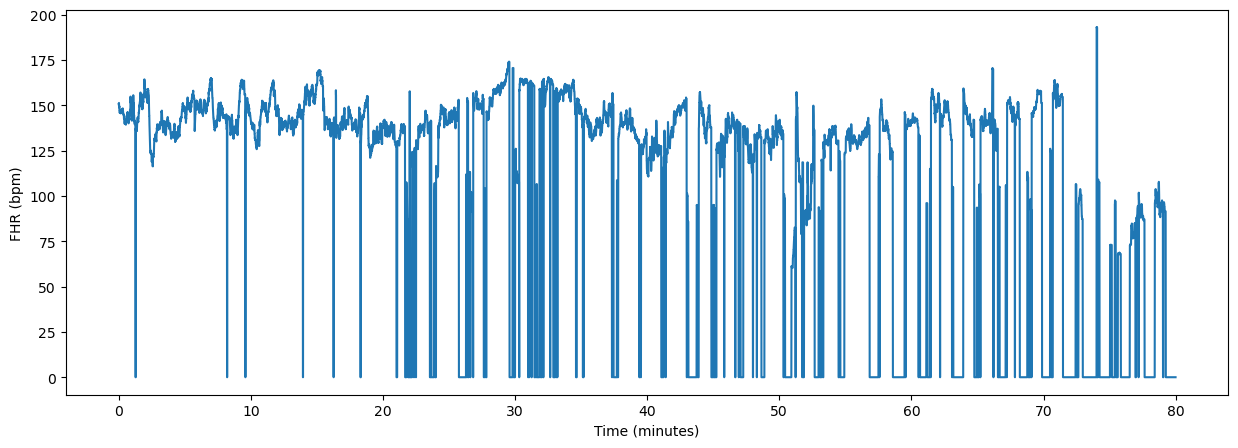

In [7]:
# Use fetal heart rate from the chosen record
fhr = chosen_record['FHR']
fhr_raw = fhr.copy()
plot_fhr(fhr)

### Replace 0 with NaN

Papers using the CTU-CHB data that also performed this step:
* Daydulo et al. 2020 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study
* Zhao et al. 2019 - DeepFHR: intelligent prediction of fetal Acidemia using fetal heart rate signals based on convolutional neural network

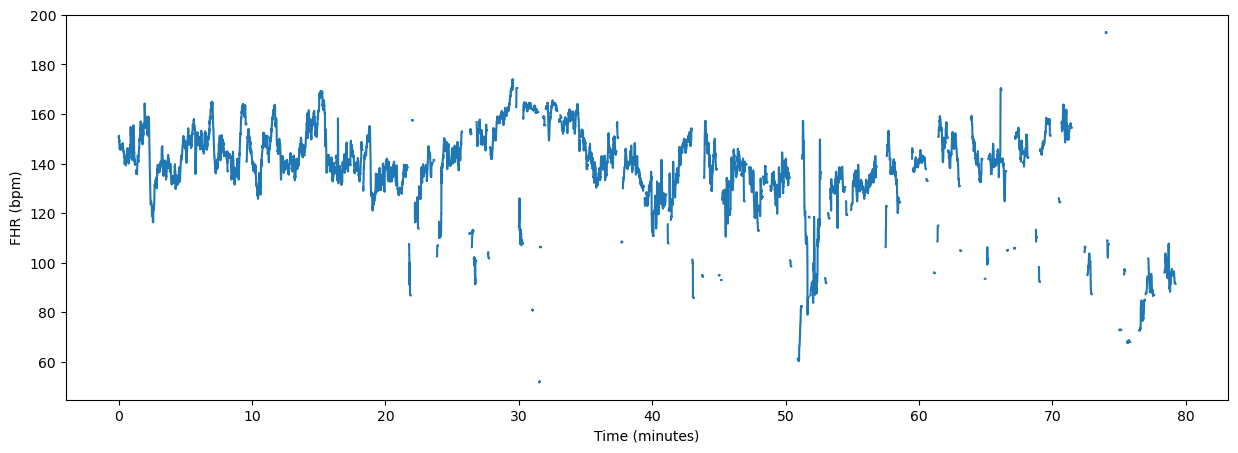

In [8]:
# Replace 0 with NaN
fhr.replace(0, np.nan, inplace=True)
plot_fhr(fhr)

### Remove NaN if occur for more than 15 consecutive seconds

Papers using the CTU-CHB data that also performed this step:
* Daydulo et al. 2020 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study
* Zhao et al. 2019 - DeepFHR: intelligent prediction of fetal Acidemia using fetal heart rate signals based on convolutional neural network

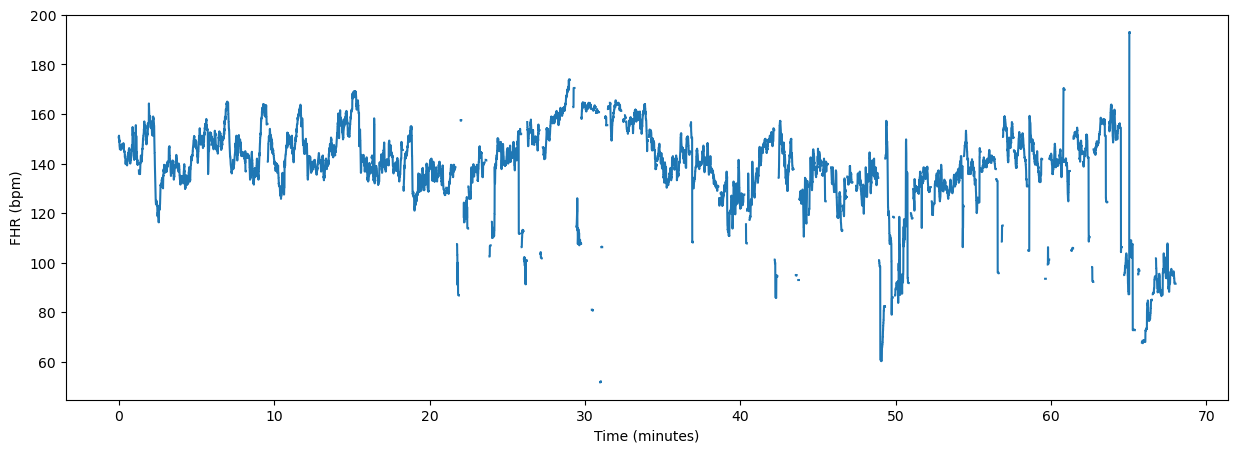

In [9]:
# Remove NaN if they occured for more than 15 seconds consecutively
# (i.e. greater than or equal to 61 quarter seconds)
na = fhr.isnull()
fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(61) & na)].reset_index(drop=True)
plot_fhr(fhr)

### Outlier detection

Less than 50bpm and more than 200bpm are not physiologic and are outliers.

Papers using the CTU-CHB data that also performed this step:
* Daydulo et al. 2020 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study
* Using cubic spline interpolation - Zhao et al. 2019 - DeepFHR: intelligent prediction of fetal Acidemia using fetal heart rate signals based on convolutional neural network

In [10]:
# Set outliers to NaN
fhr[fhr < 50] = np.nan
fhr[fhr > 200] = np.nan

### Use linear interpolation for remaining missing values

Linear interpolation treats values as equally spaced, how it works:
* 0 N N 3 becomes 0 1 2 3
* N 1 2 3 becomes 0 1 2 3
* 0 1 N N becomes 0 1 1 1

Papers using the CTU-CHB data that also performed this step:
* Daydulo et al. 2020 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study
* Using "a spline interpolation" - Zhao et al. 2019 - DeepFHR: intelligent prediction of fetal Acidemia using fetal heart rate signals based on convolutional neural network

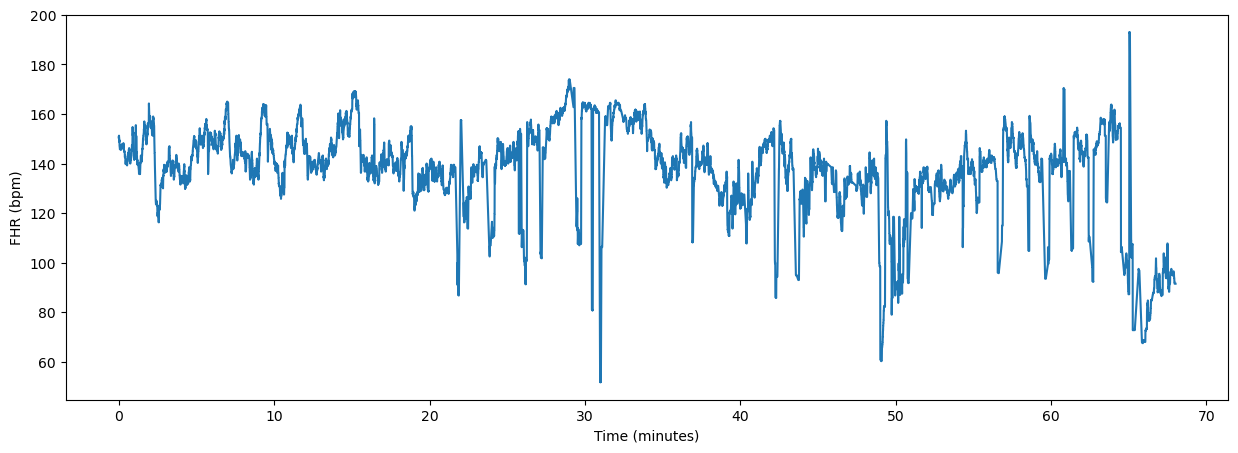

In [11]:
# Replace missing values using linear interpolation
fhr = fhr.interpolate(method='linear')
plot_fhr(fhr)

### Spike detection

Points of FHR signal more than 25 beat from the previous adjacent beat are not physiologic and are unrealistic.

Papers using the CTU-CHB data that also performed this step:
* This was their criteria for identifying spikes, but they removed them using **cubic spine interpolation** Daydulo et al. 2020 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study
* Interpolation between the first of the two adjacent points and the first of a new stable section (five adjacent samples with differences less than 10bpm) - Zhao et al. 2019 - DeepFHR: intelligent prediction of fetal Acidemia using fetal heart rate signals based on convolutional neural network

#### Method 1: As in Zhao et al. 2019

In [12]:
fhr_copy = fhr.copy()

In [13]:
# Find the difference between the current value and its prior point
# e.g. 0.5 means it was 0.5 higher than the prior point
diff = fhr - fhr.shift()

# Where difference is more than +- 25, set that following point as NaN
fhr[(diff > 25) | (diff < -25)] = np.nan

# Demonstrate how these values where calculated
display(fhr.head(3))
display(fhr.shift().head(3))
display(diff.head(3))

0    150.5
1    150.5
2    151.0
Name: FHR, dtype: float64

0      NaN
1    150.5
2    150.5
Name: FHR, dtype: float64

0    NaN
1    0.0
2    0.5
Name: FHR, dtype: float64

In [14]:
# Whilst there are any null points in the signal
while any(fhr.isnull()):

    # Find first null point through identifying first instance of maximum value
    # (which is the value True here)
    idx_null = fhr.isnull().idxmax()

    # Find the prior point (which we will use when interpolate)
    idx_prior = idx_null - 1

    # Find next point
    next = idx_null+1

    # While the null point remains null...
    while np.isnan(fhr[idx_null]):

        # Get array of 5 points (next and then the following 4)
        next_5 = np.arange(next, next+5)   

        # Find the difference among those 5 points
        next_diff = fhr[next_5].max() - fhr[next_5].min()

        # If difference among the points is less than 10bpm
        if (next_diff < 10) | (next_diff > -10):

            # Sample evenly spaced numbers of specified interval, so you're
            # linearly interpolating from first beat of those 2 adjacent
            # points in the spike, to the first beat in the five stable points
            fhr[idx_prior:next+1] = np.linspace(
                start=fhr[idx_prior],
                stop=fhr[next],
                num=(next-idx_prior+1))

        else:
            # If those points have a change greater than 10bpm, then shift on to
            # the next point and true again
            next += 1
            print('yep')

In [15]:
# Find the number of values that still have this shift
diff = fhr - fhr.shift()
((diff > 25) | (diff < -25)).value_counts()

FHR
False    16318
True         6
Name: count, dtype: int64

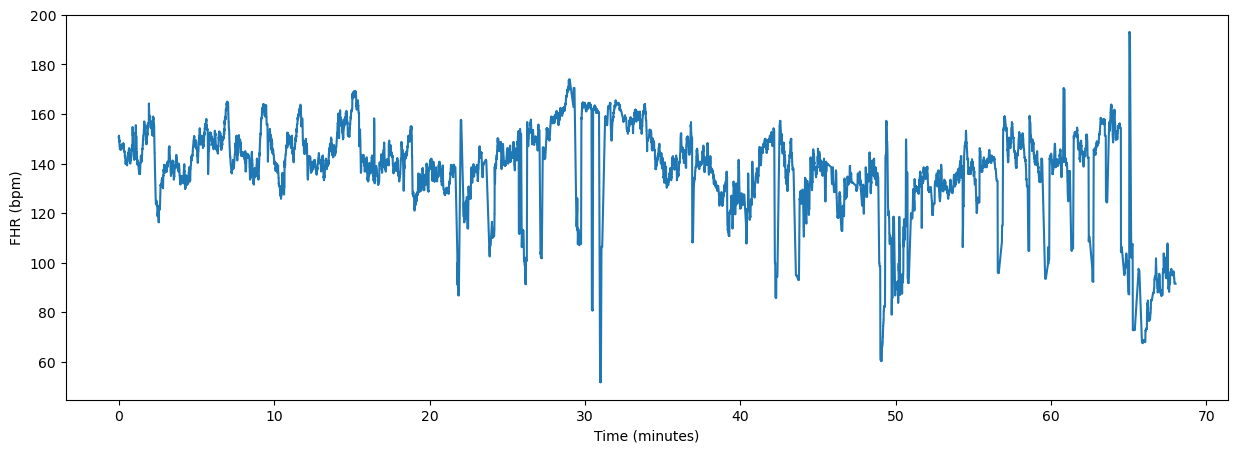

In [16]:
plot_fhr(fhr)

#### Method 2: Linear interpolation

In [17]:
fhr = fhr_copy

# Find how each value has changed from the prior value
diff = fhr - fhr.shift()

# Where difference is more than +- 25, set as NaN
fhr[(diff > 25) | (diff < -25)] = np.nan

# Replace missing values using linear interpolation
fhr = fhr.interpolate(method='linear')

In [18]:
# Find the number of values that still have this shift
diff = fhr - fhr.shift()
((diff > 25) | (diff < -25)).value_counts()

FHR
False    16318
True         6
Name: count, dtype: int64

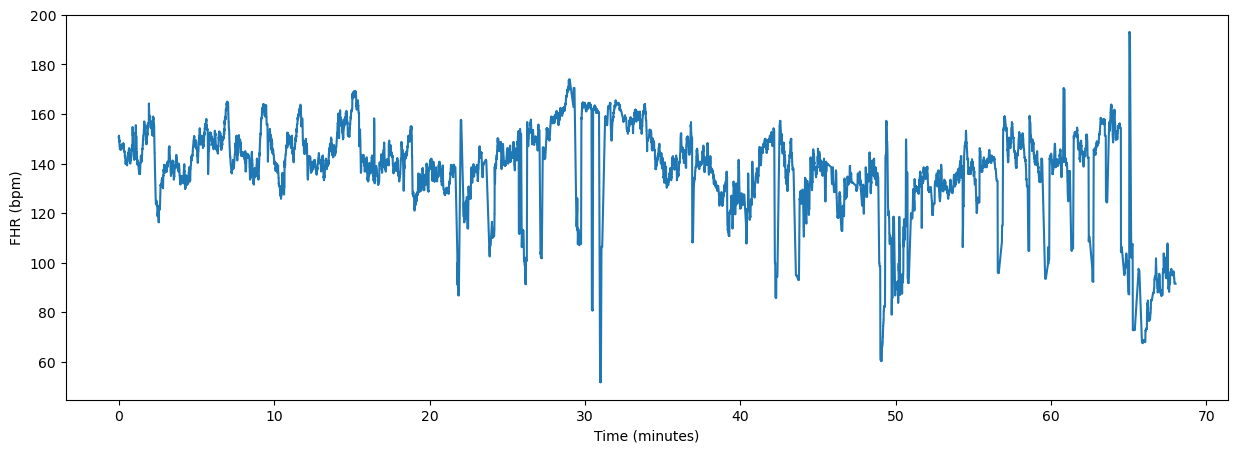

In [19]:
plot_fhr(fhr)

Compare to original...

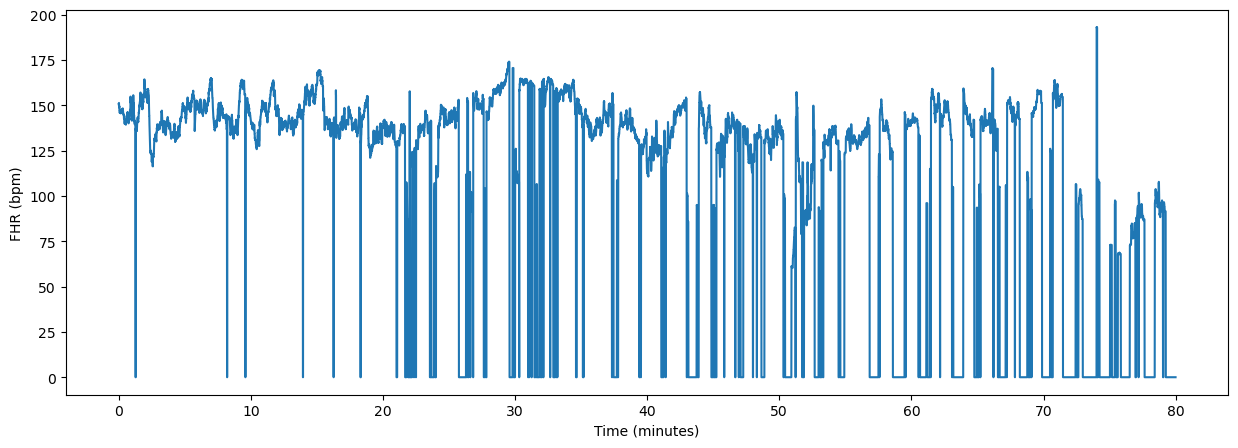

In [20]:
plot_fhr(fhr_raw)

### Segment labour

How papers using CTU-CHB data segment the data:
* **First 20 minutes (4800) and last 15 minutes (3600) used to represent first and second stage of labour** - Daydulo et al. 2020 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study
* **Take last 14.400 samples** of the UC and FHR signals - signals are in quarter seconds, and 14400 quarter seconds = 3600 seconds = 60 minutes. This is Bursa and Lhotska 2017 - The Use of Convolutional Neural Networks in Biomedical Data Processing

## FHR Cleaning Function

In [21]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(fhr.index/(60*4), fhr)
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('FHR (bpm)')
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(61) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    if show_figure:
        # Show clean trace
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(fhr.index/(60*4), fhr)
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('FHR (bpm)')
        plt.show()

    return(fhr)

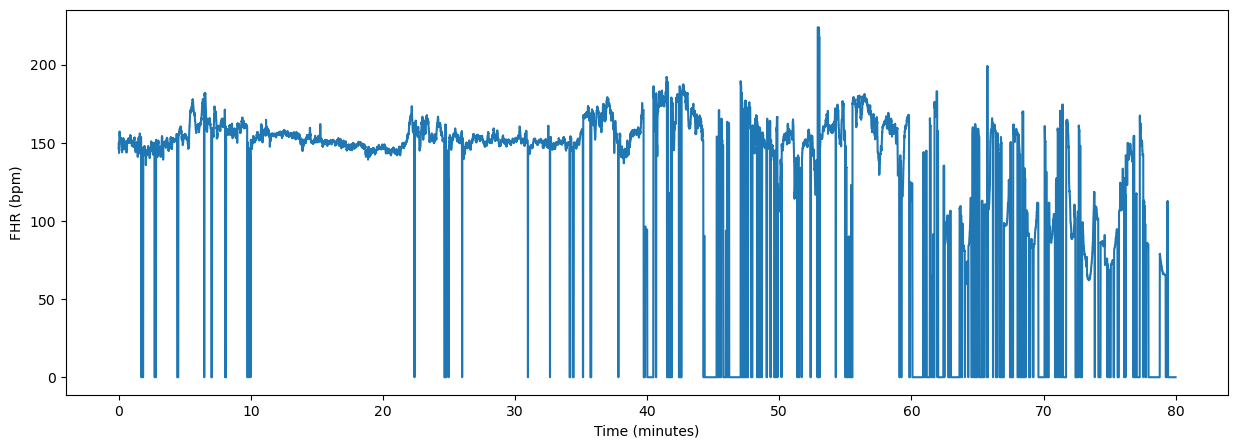

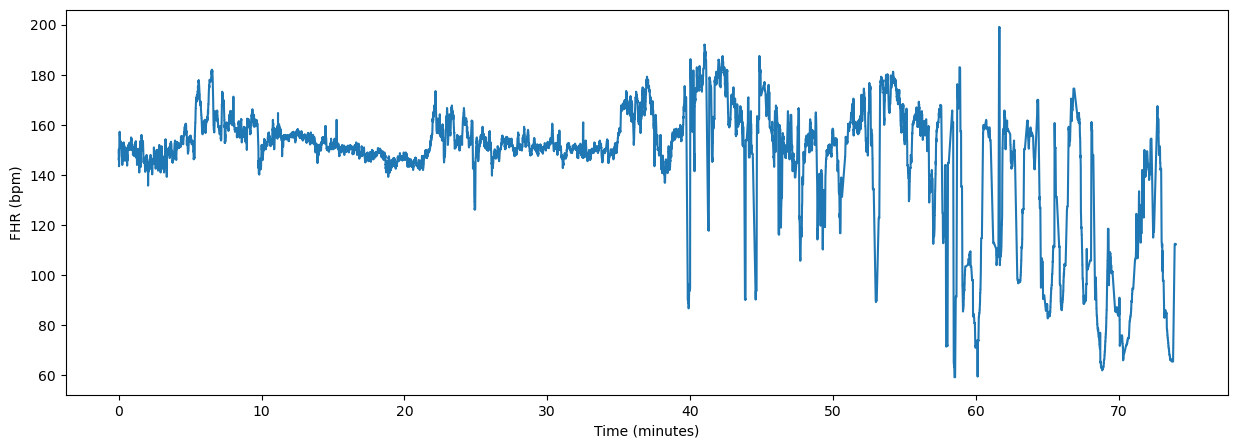

In [22]:
fhr_1002 = clean_fhr(csv_files['1002']['FHR'], show_figure=True)

## Apply FHR cleaning function to all signals

In [23]:
# Loop through all the csv file dataframes, apply cleaning and then save
for key, value in csv_files.items():
    df = clean_fhr(value['FHR'])
    df.to_csv(f'data_fhr_clean/{key}.csv', index=False)

## Uterine Contraction (UC)

### View raw trace

<Axes: >

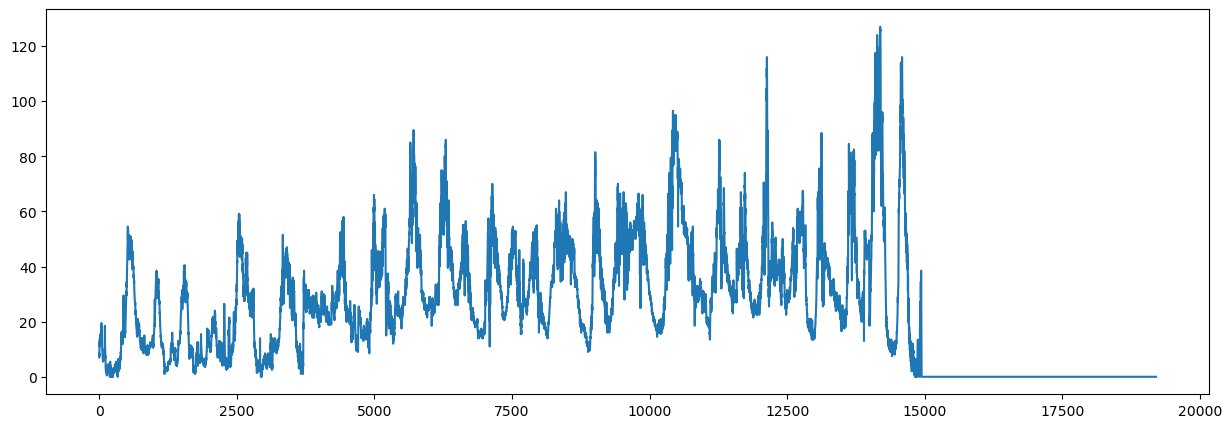

In [24]:
# Used UC from chosen record
uc = chosen_record['UC']
uc.plot(figsize=(15, 5))

### Replace 0 with NaN

<Axes: >

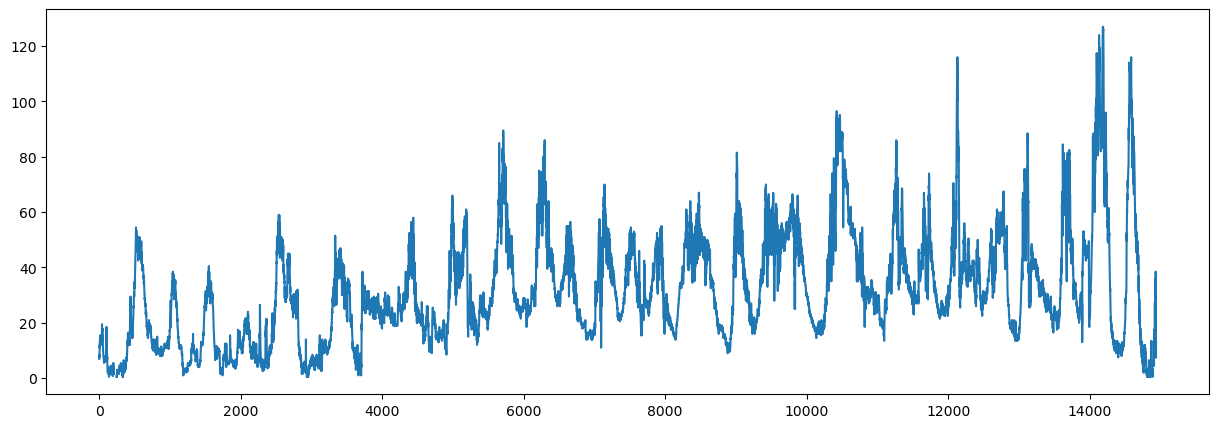

In [25]:
# Replace 0 with NaN
uc.replace(0, np.nan, inplace=True)
uc.plot(figsize=(15, 5))

In [26]:
uc.isnull().value_counts()

UC
False    14843
True      4357
Name: count, dtype: int64